In [2]:
import h5py
import numpy as np
import pandas as pd
import pickle
import common
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import os
sys.path.insert(1, './ob_raw/')
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_merged_data(path_to_folder):
    with h5py.File(path_to_folder + "/prep_data2.h5", "r") as data:
        with h5py.File(path_to_folder + "/result.h5", "r") as targets:
            with h5py.File(path_to_folder + "/prep_data3.h5", "r") as data3:
                X = np.array(data["data"])
                X = X.reshape(X.shape[0], -1)
                X2 = np.array(data3["data"])
                X = np.concatenate([X, X2.reshape(X2.shape[0], -1)], axis = 1)
                y = np.array(targets["Return"]["Res"]) * 100
                del data
                del targets
                return X, y

def scoring(predictions, y):
    l = 0
    r = 5000
    plt.figure(figsize=(12,5))
    plt.plot(predictions[l:r], label = "pred")
    plt.plot(y[l:r], label = "return")
    plt.legend()
    plt.show()
    t = predictions - y
    score_1 = np.sum(t**2) / y.shape[0]
    score_2 = np.sum(y**2)/y.shape[0]
    print("corr_coef: ", np.corrcoef(predictions.reshape(-1), y)[0][1])
    print("improvment, %: ", 1 - score_1 / score_2)
    
def preprocess(path_to_folder, is_fit):
    print("warning: it'll take approx an hour")
    if os.path.exists(path_to_folder + "/prep_data2.h5"):
        print("preprocessed files already exist, delete them if sure to run preprocessing again")
        return
    params = {
        "ob_window": 120
    }
    Preprocessor_1 = common.ExtFeatPrep(path_to_folder, params, is_fit)
    Preprocessor_1.run()

    ### PREPROCESSING 2
    params = {
                "depth_levels" : 25,
                "price_precision" : 0.25, 
                "quantity_max" : 15.0, 
                "n_batches" : 100
            }
    Prep = common.DecomposePreprocessor(path_to_folder, params)
    Prep.run()

def pipeline_from_scratch(path_to_folder, is_fit):
    global model
    X, y = get_merged_data(path_to_folder)
    print("X.shape: ", X.shape)
    if is_fit:
        model = MLPRegressor(hidden_layer_sizes=(10, 5), activation="relu")
        #model = Ridge()
        model.fit(X, y)
    pred = model.predict(X)
    scoring(pred, y)
    del X
    del y

In [4]:
### set this with propper paths

# for each path there should be files data.h5 and result.h5
path_to_train_folder = "./116.203.79.48/data/btc_insample/"
path_to_test_folder = "./116.203.79.48/data/btc_outsample/"

In [4]:
### RUN ONLY ONCE

# this will produce new files with preprocessed data
# after execution restart kernel if out of memory
# takes an hour or so (only one worker used)
preprocess(path_to_train_folder, is_fit=True)
preprocess(path_to_test_folder, is_fit=False)

scaler fitted and dumped to  scaler.pkl
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
scaler loaded from  scaler.pkl
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


X.shape:  (7897313, 58)


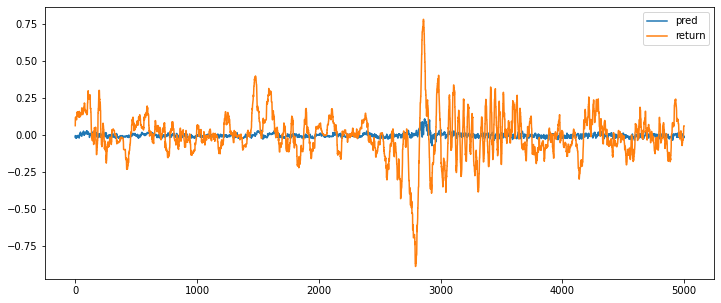

corr_coef:  0.17633655434763817
improvment, %:  0.026552684928490278


In [5]:
### FIT MODEL

# score corresponds to predicting on training data
# chart is just a random subsegment
pipeline_from_scratch(path_to_train_folder, is_fit=True)

X.shape:  (1974329, 58)


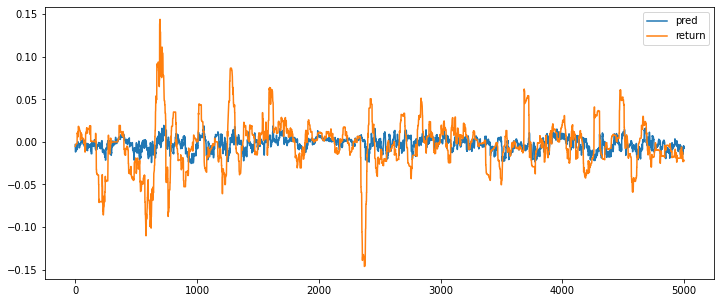

corr_coef:  0.04298455488639712
improvment, %:  -0.016911178276653338


In [6]:
### PREDICT ON TEST DATA
pipeline_from_scratch(path_to_test_folder, is_fit=False)